In [1]:
"""
Created on Sun Feb 12 2022

@author: Kevin Taylor
"""
# computation packages
import numpy as np
import pandas as pd
from math import *
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import openpyxl
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from prophet import Prophet


# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from modeling_utils import * # local processing function

In [2]:
weekly_usage = pd.read_csv(
    '../Raw Data/weekly_usage.csv',
    index_col = 0
    ) # read the pre-processed file
weekly_overall = create_kwh_dataframe(weekly_usage) # apply processing function to convert to ts DataFrame
weekly_overall['week'] = weekly_overall.index 
weekly_overall = weekly_overall.groupby('week').mean() # group for all accounts combined, mean usage in kWh

<Figure size 720x504 with 0 Axes>

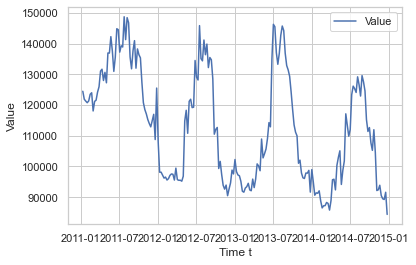

<Figure size 720x504 with 0 Axes>

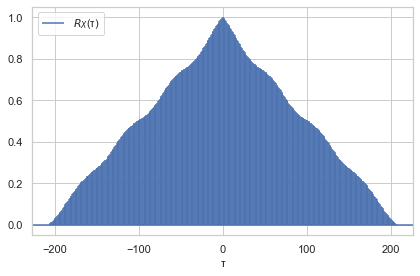

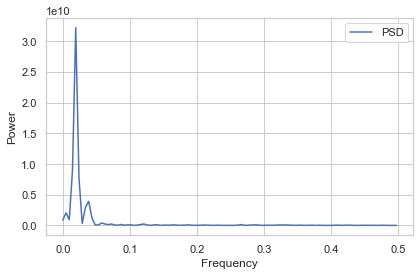

Max Power at period 51.75


In [3]:
ts_plots(weekly_overall, auto_lags = None) # Plot the timeseries, autocorrelation and PSD

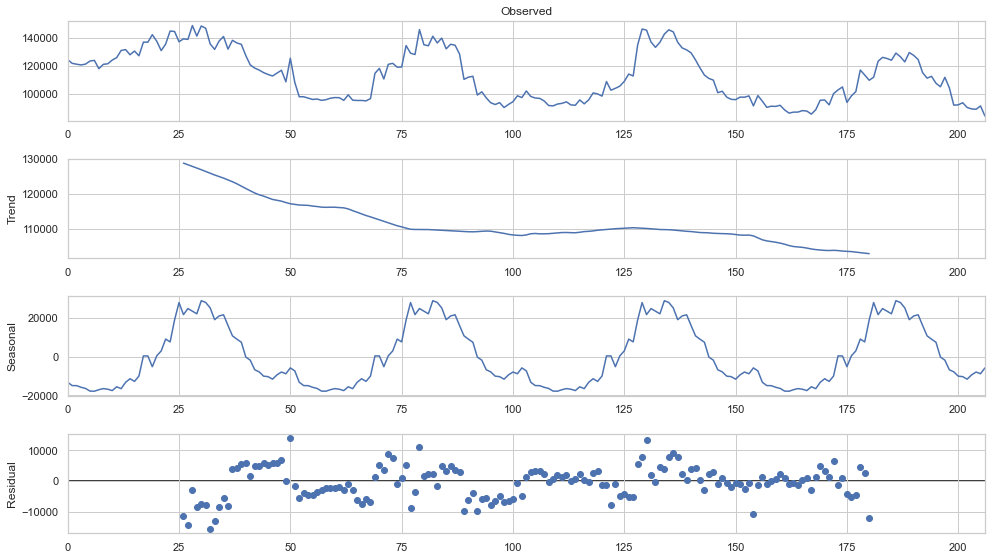

In [4]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=14)
result = seasonal_decompose(weekly_overall.value.values, period = 52, model='additive') # seasonal decomposition of overall ts
fig = result.plot()
# Appears to have 1st order trend with seasonal component, period of 52

In [24]:
train, valid, fit, predictions = train, test_sets, fit, test_predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
    weekly_overall,
    round(len(weekly_overall)*0.2),
    round(len(weekly_overall)*0.2), 
    0, 1, 1, 0, 1, 1, 52,
    type = 'valid')

MAPE = 12.79%


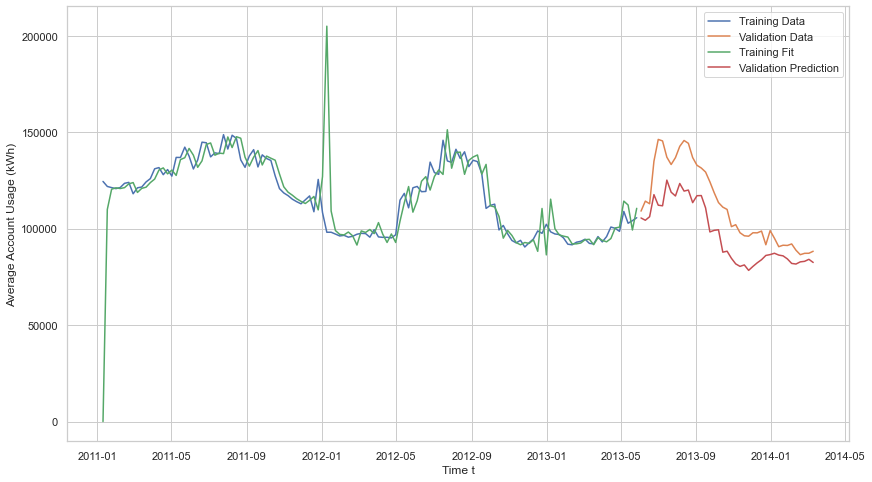

In [25]:
plt.plot(train, label = 'Training Data') # plot validation vs. fit
plt.plot(valid, label = 'Validation Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(predictions, label = 'Validation Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(valid.value.values, predictions.values)))

In [31]:
# Hyperparameter tuning on overall data
best_p, best_d, best_q = np.nan, np.nan, np.nan
best_mape = 1e9
for p in [0, 1, 2]:
    for d in [0, 1, 2]:
        for q in [0, 1, 2]:
            train, valid, fit, predictions = train, test_sets, fit, test_predictions = walk_forward_validation_sarimax( # try to fit one validation set with a vanilla SARIMAX
                weekly_overall,
                round(len(weekly_overall)*0.2),
                round(len(weekly_overall)*0.2), 
                p, d, q, p, d, q, 52,
                type = 'valid')
            current_mape =  MAPE(valid.value.values, predictions.values)
            print('p={}, d={}, q={}, MAPE={}'.format(p, d, q, current_mape))
            if current_mape < best_mape:
                best_mape = current_mape
                best_p, best_d, best_q = p, d, q


p=0, d=0, q=0, MAPE=1.0
p=0, d=0, q=1, MAPE=0.6383864520049037


In [ ]:
account_numbers = []
account_train = []
account_valid = []
account_test = []
account_fit = []
account_valid_fit = []
account_prediction = []
account_mape = []
account_errors = []
for account_number in tqdm(weekly_usage.account.unique()):
    try:
        df_account = create_kwh_dataframe(weekly_usage[weekly_usage.account == account_number]).drop(columns = ['account'])
        train, test, fit, prediction = walk_forward_validation_sarimax(df_account, round(len(df_account)*0.25), round(len(df_account)*0.2), 0, 1, 1, 0, 1, 1, 52)
        account_numbers.append(account_number)
        account_train.append(train)
        account_test.append(test)
        account_fit.append(fit)
        account_prediction.append(prediction)
        account_mape.append(MAPE(test.value.values, prediction.values))
    except:
        account_errors.append(account_number)
        continue

 66%|███████████████████████████▏             | 245/370 [48:14<07:56,  3.81s/it]

In [1]:
plt.hist(np.array(account_mape)*100, bins = np.arange(0, 200, 10))
plt.xticks(np.arange(0, 200, 10))
plt.xlabel('MAPE (%)')
plt.ylabel('Number of Accounts')

NameError: name 'plt' is not defined

In [ ]:
index = account_mape.index(min(account_mape))
plt.plot(account_train[index], label = 'Training Data')
plt.plot(account_test[index], label = 'Test Data')
plt.plot(account_fit[index], label = 'Training Fit')
plt.plot(account_prediction[index], label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(test.value.values, prediction.values)))

In [ ]:
# Total MAPE
mapes  = []
for i in np.arange(len(account_mape)):
    actual = account_test[i].value.values
    pred = account_prediction[i].values
    mapes = mapes + (np.abs((actual - pred))/(actual)).tolist()
print('Total MAPE is {:.1%}'.format(np.mean(mapes)))
print('Median MAPE is {:.1%}'.format(np.median(mapes)))

In [26]:
## FB Prophet ##
model = Prophet()
prophet_train = train_test_split(weekly_overall, round(0.2*len(weekly_overall)))[0]
prophet_test = train_test_split(weekly_overall, round(0.2*len(weekly_overall)))[1]

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)




prophet_train['ds'] = prophet_train.index.values
prophet_train.rename(columns = {'value': 'y'}, inplace = True)
prophet_test['ds'] = prophet_test.index.values
prophet_test.rename(columns = {'value': 'y'}, inplace = True)

In [28]:
model.fit(prophet_train)
prediction = model.predict()

23:32:40 - cmdstanpy - INFO - Chain [1] start processing
23:32:40 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
train = prophet_train
test = prophet_test
fit = model.predict()[['ds', 'yhat']].set_index('ds')
prediction = model.predict(pd.DataFrame({'ds': prophet_test['ds']}))[['ds', 'yhat']].set_index('ds')

MAPE = 16.75%


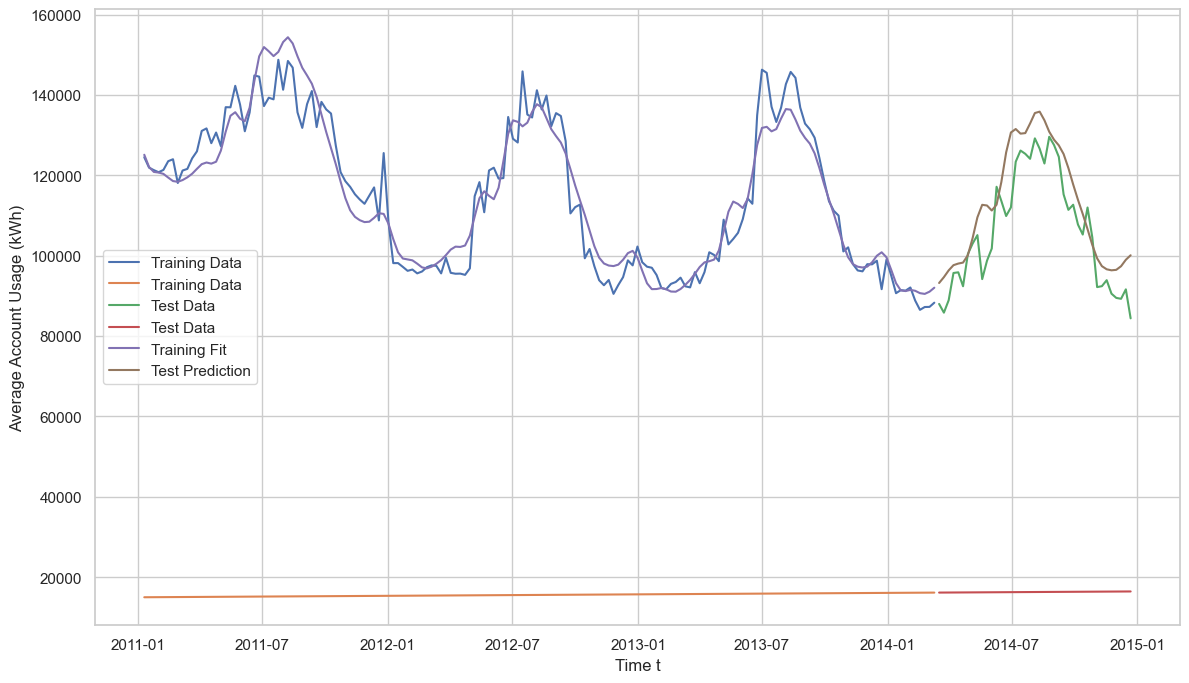

In [46]:
plt.plot(train, label = 'Training Data')
plt.plot(test, label = 'Test Data')
plt.plot(fit, label = 'Training Fit')
plt.plot(prediction, label = 'Test Prediction')
plt.xlabel('Time t')
plt.ylabel('Average Account Usage (kWh)')
plt.legend()
print("MAPE = {:0.2%}".format(MAPE(test.y.values, prediction.values)))

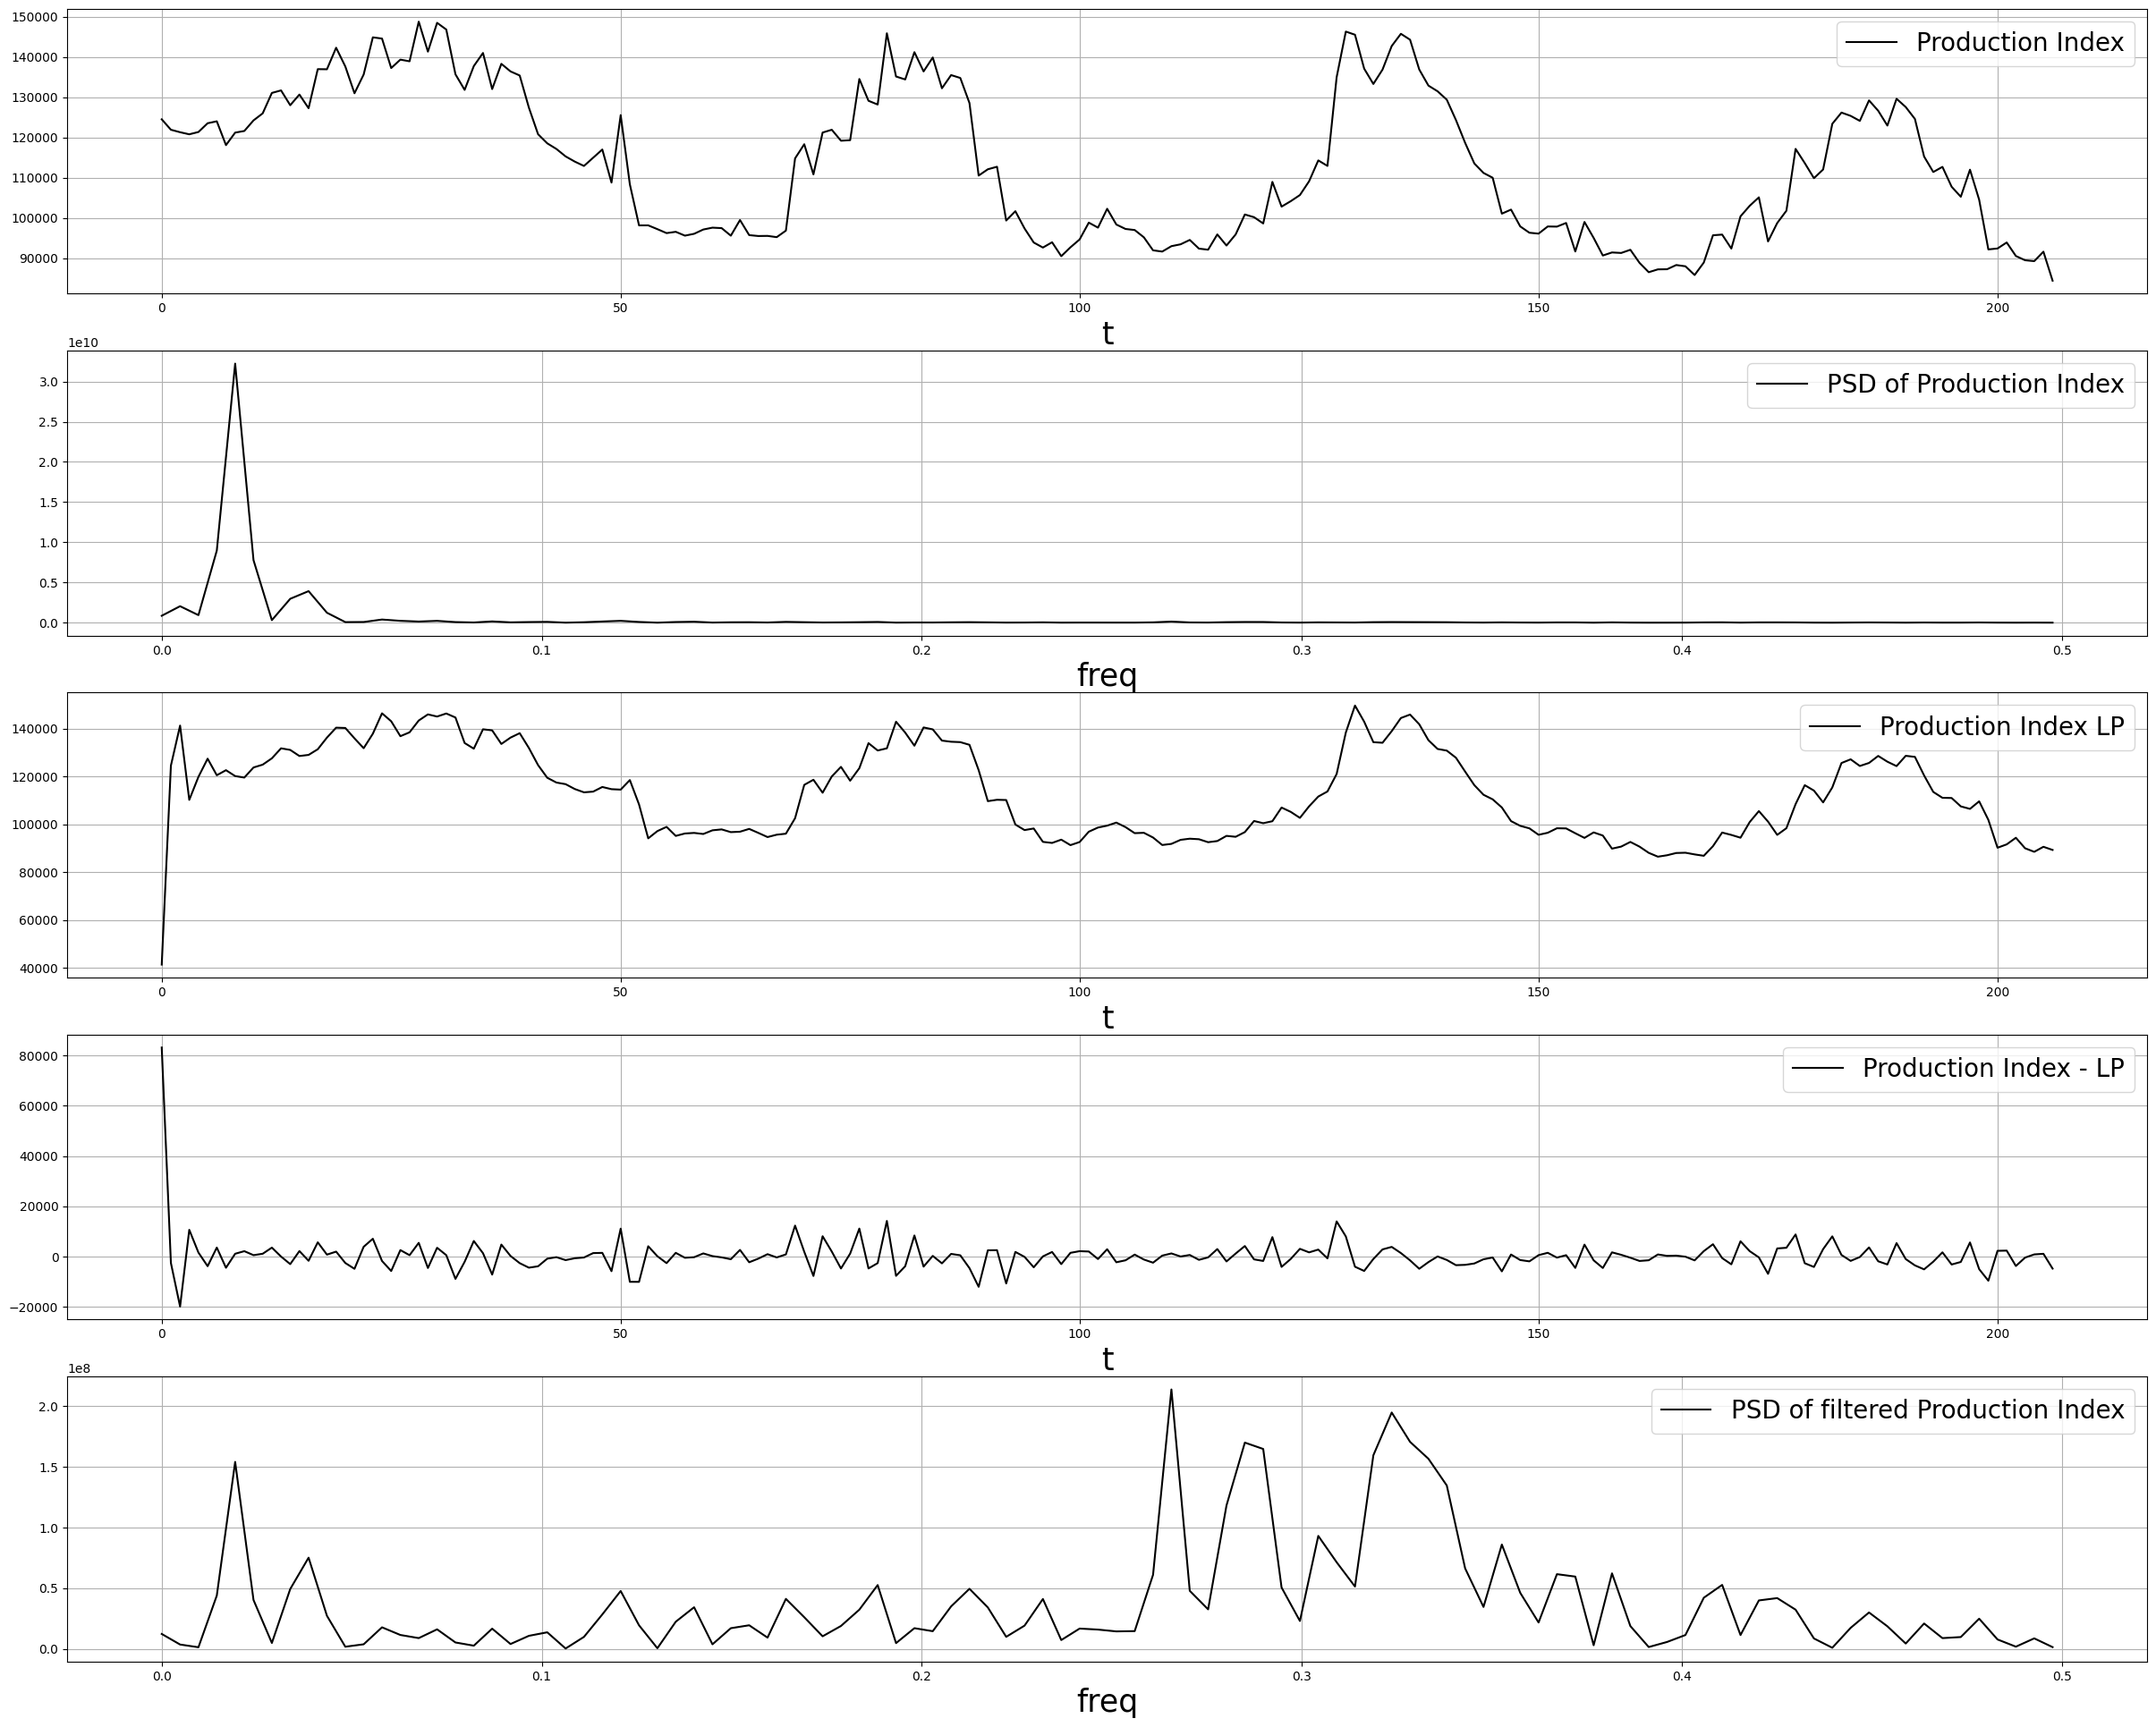

In [ ]:
# Low Pass Filter for overall
t = weekly_overall.t
sig = weekly_overall.value.values
RMSE = 1e9
fss=0
order=0

for i in np.arange(3,20):
    for j in np.arange(i,60):
        sos = signal.butter(i, 1, 'lowpass', fs=j, output='sos')
        filtered = signal.sosfilt(sos, sig)
        MSE = np.square(sig-filtered).mean() 
        if(RMSE > math.sqrt(MSE)):
            RMSE = math.sqrt(MSE)
            order = i
            fss = j
            
sos = signal.butter(order, 1, 'lowpass', fs=fss, output='sos')
filtered = signal.sosfilt(sos, sig)
fig = plt.figure(figsize=(30, 24))
ax1 = plt.subplot(511)
plt.plot(t, sig,'k')
plt.xlabel('t',fontsize=25)
plt.legend(['Production Index'],fontsize=20)
freqs, psd = signal.welch(sig)
plt.grid(True)
ax2 = plt.subplot(512)
plt.plot(freqs, psd,'k')
plt.xlabel('freq',fontsize=25)
plt.legend(['PSD of Production Index'],fontsize=20)
plt.grid(True)
ax3 = plt.subplot(513)
plt.plot(t, filtered,'k')
plt.xlabel('t',fontsize=25)
plt.legend(['Production Index LP'],fontsize=20)
plt.grid(True)
ax4 = plt.subplot(514)
plt.plot(t,sig-filtered,'k')
plt.xlabel('t',fontsize=25)
plt.legend(['Production Index - LP'],fontsize=20)
freqs, psd = signal.welch(sig-filtered)
plt.grid(True)
ax5 = plt.subplot(515)
plt.plot(freqs, psd,'k')
plt.xlabel('freq',fontsize=25)
plt.legend(['PSD of filtered Production Index'],fontsize=20)
plt.grid(True)
# plt.savefig('ProductionIndex_Butterworth.png')
plt.show()
MSE = np.square(sig-filtered).mean()
RMSE = math.sqrt(MSE)

In [ ]:
import statsmodels.formula.api as sm
## GLM ##

model = sm.GLM()
GLM_train = train_test_split(weekly_overall, round(0.2*len(weekly_overall)))[0]
GLM_test = train_test_split(weekly_overall, round(0.2*len(weekly_overall)))[1]

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

model = sm.GLM(y_train, sm.add_constant(X_train))
results = model.fit()
y_pred = results.predict(sm.add_constant(X_test))
